In [1]:
import numpy as np
import networkx as nx
import experiments
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import copy
from mpl_toolkits.axes_grid1 import Divider, Size
matplotlib.rcParams['figure.figsize'] = (4.0,4.0)
matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 17.0
path = 'plots_new/'

# Evaluating success rates of different attacks

Loading the FB dataset

In [2]:
graph_test = experiments.GNPGraph(30, 0.5)

In [3]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [4]:
comms = nx.community.greedy_modularity_communities(G)

Defining the attacks types to be used

In [5]:
attack_names = ['Inf 1 Rand', 'Def 1 Rand', 'Inf 1 Friend', 'Def 1 Friend', 
               'Inf 5 Rand', 'Inf 20 Rand', 'Def 5 Comm', 'Def 20 Comm', 
               'Inf+Def 5 Comm', 'Inf+Def 20 Comm', '2 Inf 5 Comm', '2 Def 5 Comm',
                'Inf 5 Def 5 Comm', '2 Inf 20 Comm', '2 Def 20 Comm', 'Inf 20 Def 20 Comm',
                'Def Big Comm']
attack_names_short = {attack_names[d]: 'A%d' % d for d in range(0, len(attack_names))}
def gen_attacks(n, n_mal, t1, t2, comm):
    attacks = []
    attacks.append( [[1, 0, n_mal-1, 'Random']])
    attacks.append( [[0, 1, n_mal, 'Random']])
    #an attack where no one is his friend
    attacks.append( [[1, 0, n_mal-1, 'Friends']])
    attacks.append( [[0, 1, n_mal, 'Friends']])
    
    #Try m = 1%, 5%, 10%, 15%, ..., 35%
    attacks.append( [[t1, 0, n_mal-t1, 'Random']] )
    attacks.append( [[t2, 0, n_mal-t2, 'Random']] )
    attacks.append( [[0, t1, n_mal-t1, comm]] )
    attacks.append( [[0, t2, n_mal-t2, comm]] )
    
    attacks.append( [[t1, t1, n_mal-t1, comm]] )
    attacks.append( [[t2, t2, n_mal-t2, comm]] )
    
    attacks.append( [[t1, 0, n_mal//2-t1, comm], [t1, 0, n_mal//2-t1, comm]] )
    attacks.append( [[0, t1, n_mal//2, comm], [0, t1, n_mal//2, comm]] )
    attacks.append( [[t1, 0, n_mal//2-t1, comm], [0, t1, n_mal//2, comm]] )
    attacks.append( [[t2, 0, n_mal//2-t2, comm], [t2, 0, n_mal//2-t2, comm]] )
    attacks.append( [[0, t2, n_mal//2, comm], [0, t2, n_mal//2, comm]] )
    attacks.append( [[t2, 0, n_mal//2-t2, comm], [0, t2, n_mal//2, comm]] )
    
    attacks.append( [[0, len(comm)-n_mal, n_mal, comm]] )
    
    return attacks

In [6]:
def collect_data(attacks, attack_names, g, g_name, max_adv, epsilon, thresh_values, attack_values, reps):
    #labels = ['RR+Laplace, Response', 'RR+Laplace, Input', 'RR, Response', 'RR, Input', 'Naive, Response', 'Naive, Input']
    labels = ['RR+Laplace, Response', 'RR, Response', 'Naive, Response']
    E = [experiments.ResponseLaplaceManipulation(g, max_adv, epsilon, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]), 
         #experiments.InputLaplaceManipulation(g, max_adv, epsilon, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]),
         experiments.ResponseRRManipulation(g, max_adv, epsilon, 1e-6, [0.7], [0.8, 0.5]),
         #experiments.InputRRManipulation(g, max_adv, epsilon, 1e-6, [0.7], [0.8, 0.5]),
         experiments.ResponseRRNaiveManipulation(g, max_adv, epsilon, 1e-6, [0.7], [0.8, 0.5])
         #experiments.InputRRNaiveManipulation(g, max_adv, epsilon, 1e-6, [0.7], [0.8, 0.5])
        ]
    
    data = []
    for x in range(0, reps):
        for av in attack_values.keys():
            for a_i in range(0, len(attacks)):
                A = copy.deepcopy(attacks[a_i])
                #if av == 'strong':
                #    for a in A:
                #        a[1] *= 3
                for i in range(0, len(E)):
                    E[i].reset_attacks()
                E[0].add_attacks(A)
                for i in range(1, len(E)):
                    E[i].set_attacks_like(E[0])
                for tv in thresh_values.keys():
                    for i in range(0, len(E)):
                        if 'Naive' in labels[i]:
                            E[i].inflation_factors = (1.0,)
                        else:
                            E[i].inflation_factors = attack_values[av]   
                        E[i].threshold_reduction = thresh_values[tv]
                        d = E[i].get_results(False)
                        h = {'Protocol': labels[i], 'Attack': attack_names[a_i], 'Attack Strength': av, 'Threshold Strength': tv, 'Eps': epsilon, 'Graph': g_name,
                            'Mal Max Error': d[0][0], 'Mal L2 Error': d[0][1], 'Mal Mean Error': d[0][2], 'Mal T Nan': d[1][0], 'Mal T Tot': d[1][1], 'Mal Nan': d[2],
                            'Hon T Max Error': d[3][0], 'Hon T L2 Error': d[3][1], 'Hon T Mean Error': d[3][2], 'Hon T Nan': d[4][0], 'Hon T Tot': d[4][1],
                            'Rest Max Error': d[5][0], 'Rest L2 Error': d[5][1], 'Rest Mean Error': d[5][2], 'Rest Nan': d[6][0], 'Rest Tot': d[6][1], 'l1norm': d[7]
                        }
                        data.append(h)
    return data

Parameters used for the protocols and attacks. We determined these values empirically, at the "sweet spot" where no honest users are flagged, and malicious users are sometimes flagged.

In [7]:
thresh_values = {'med': (0.9, 0.5, 0.5)}
attack_values = {'strong': (0.17, 0.17)}

In [8]:
atx = gen_attacks(g, 40, 6, 10, list(comms[1]))

## Collecting and analyzing attack data for FB graph

In [9]:
#df = collect_data(atx, attack_names, g, 'FB', 40, 0.7, thresh_values, attack_values, 20)

In [10]:
import pickle
#pickle.dump(df, open('df1.pkl', 'wb'))
df = pickle.load(open('df1.pkl', 'rb'))

In [11]:
D = pd.DataFrame(df).drop('Graph', axis=1)

In [12]:
dat = D.groupby(['Protocol', 'Threshold Strength', 'Attack', 'Attack Strength']).mean()

In [13]:
#lab = dat.index.get_level_values('Protocol').unique()
lab = ['Naive, Response', 'RR, Response', 'RR+Laplace, Response']
attack = dat.index.get_level_values('Attack').unique()
attack_strength = dat.index.get_level_values('Attack Strength').unique()

In [14]:
inf_attack = [a for a in attack if 'Inf' in a]
def_attack = [a for a in attack if 'Def' in a]
best_inf_attacks = []
best_def_attacks = []
best_attacks = []

plots_new/fb_inf_strong.pdf
plots_new/fb_def_strong.pdf
plots_new/fb_tot_strong.pdf


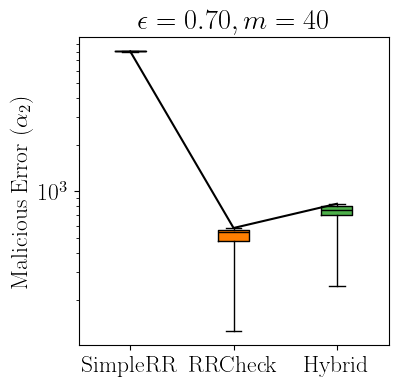

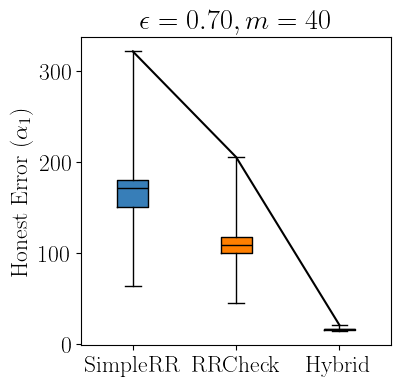

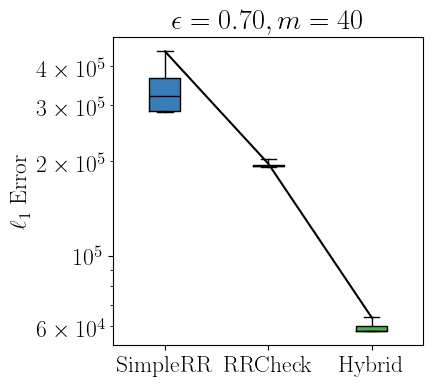

In [15]:

def plot_data(dat, attacks, s, err, y_lab, name, num_mal, log=False):
    fig, ax = plt.subplots()
    graph_data = []
    for a in attacks:
        pts = []
        for p in lab:
            if err == 'rob':
                pts.append(dat.loc[p, 'med', a, s]['Mal Max Error'])
            elif err == 'acc':
                pts.append(dat.loc[p, 'med', a, s]['Hon T Max Error'])
            elif err == 'total':
                pts.append(dat.loc[p, 'med', a, s]['l1norm'])
                #pts.append(np.sqrt(dat.loc[p, 'med', a, s]['Hon T L2 Error'] ** 2 + dat.loc[p, 'med', a, s]['Mal L2 Error'] ** 2))
                #pts.append( dat.loc[p, 'med', a, s]['Hon T L2 Error'] + dat.loc[p, 'med', a, s]['Mal L2 Error'] )
        #ax.plot(pts, color=c, alpha=0.5)
        graph_data.append([a] + pts)
    PD = pd.DataFrame(graph_data).set_index(0)
    bplot = ax.boxplot(PD, tick_labels=['SimpleRR', 'RRCheck', 'Hybrid'], whis=(0,100))
    for box, color in zip(bplot['boxes'], CB_color_cycle[0:3]):
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax.add_patch(matplotlib.patches.Polygon(box_coords, facecolor=color))
    for med in bplot['medians']:
        med.set_color('k')
    PD['metric 1'] = (PD[2] + PD[3]) / 2
    PD = PD.sort_values('metric 1')
    worst_attacks = list(PD.iloc[-2:, :].index)
    plt.plot([1,2,3], PD.loc[worst_attacks[-1], [1,2,3]], c='k')
    ax.set_ylabel(y_lab)
    if log:
        ax.set_yscale('log')
    #ax.set_ylim([1, 5*4000])
    ax.set_title('$\\epsilon=%0.2f, m=%d$' % (dat['Eps'].mean(), num_mal))
    if isinstance(name, str):
        print(name)
        plt.savefig(name, bbox_inches = "tight")
    return worst_attacks

best_inf_attacks += plot_data(dat, inf_attack, 'strong', 'rob', 'Malicious Error ($\\alpha_2$)', path + 'fb_inf_strong.pdf', 40, True)
best_def_attacks += plot_data(dat, def_attack, 'strong', 'acc', 'Honest Error ($\\alpha_1$)', path + 'fb_def_strong.pdf', 40, False)
best_attacks += plot_data(dat, attack, 'strong', 'total', '$\\ell_1$ Error', path + 'fb_tot_strong.pdf', 40, True)

### Some particular ratios used in the paper

In [16]:
print( dat.loc['Naive, Response', :, :, :]['Mal Max Error'].max() / dat.loc['RR+Laplace, Response', :, :, :]['Mal Max Error'].max() )
print( dat.loc['Naive, Response', :, :, :]['Mal Max Error'].max() / dat.loc['RR, Response', :, :, :]['Mal Max Error'].max() )

9.650850941519806
13.838094405248421


In [17]:
print( dat.loc['Naive, Response', :, :, :]['Hon T Max Error'].max() / dat.loc['RR+Laplace, Response', :, :, :]['Hon T Max Error'].max() )
print( dat.loc['RR, Response', :, :, :]['Hon T Max Error'].max() / dat.loc['RR+Laplace, Response', :, :, :]['Hon T Max Error'].max() )

15.454535522693034
9.871882062078093


In [18]:
def get_honest_nans(dat):
    return dat.iloc[ np.where(dat['Hon T Nan'] + dat['Rest Nan'] > 0)[0] ]
get_honest_nans(dat)

,,,,Eps,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,Mal T Tot,Mal Nan,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot,l1norm
Protocol,Threshold Strength,Attack,Attack Strength,,,,,,,,,,,,,,,,,,


In [19]:
best_attacks

['Def Big Comm', '2 Inf 20 Comm']

In [20]:
#How many malicious users are being caught in both strong and weak attacks?
def get_pct_disq(D):
    X = D.copy()
    X['PCT Disq'] = X['Mal T Nan'] / X['Mal T Tot']
    return X[['Protocol', 'Attack Strength', 'PCT Disq']].groupby(['Protocol', 'Attack Strength']).mean()['PCT Disq']
get_pct_disq(D)

Protocol              Attack Strength
Naive, Response       strong             0.000000
RR+Laplace, Response  strong             0.621167
RR, Response          strong             0.632250
Name: PCT Disq, dtype: float64

## Collecting and analyzing attack data for Random graph

In [21]:
gnp = experiments.GNPGraph(4000, 0.5)
comms_gnp = np.random.choice(range(0, 4000), 600, replace=False)

In [22]:
thresh_values = {'med': (0.9, 0.5, 0.5)}
attack_values = {'strong': (0.17, 0.17)}
atx_gnp = gen_attacks(gnp, 40, 6, 10, list(comms_gnp))

In [23]:
#df_gnp = collect_data(atx_gnp, attack_names, gnp, 'GNP', 40, 0.7, thresh_values, attack_values, 20)

In [24]:
#pickle.dump(df_gnp, open('df3.pkl', 'wb'))
df_gnp = pickle.load(open('df3.pkl', 'rb'))

In [25]:
dat_gnp = pd.DataFrame(df_gnp).drop('Graph', axis=1)

In [26]:
dat_gnp = dat_gnp.groupby(['Protocol', 'Threshold Strength', 'Attack', 'Attack Strength']).mean()

plots_new/gnp_inf_strong.pdf
plots_new/gnp_def_strong.pdf
plots_new/gnp_tot_strong.pdf


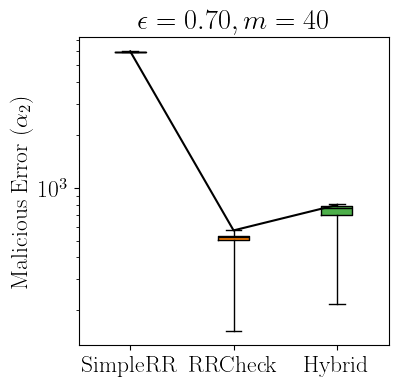

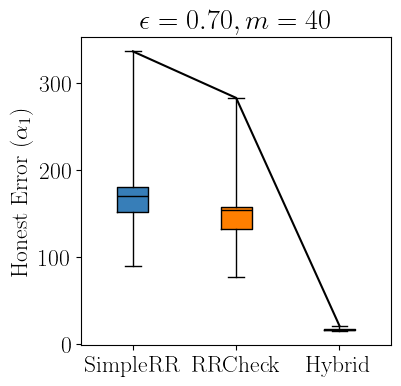

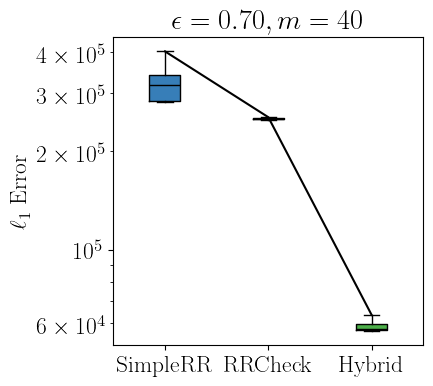

In [27]:
best_inf_attacks += plot_data(dat_gnp, inf_attack, 'strong', 'rob', 'Malicious Error ($\\alpha_2$)', path + 'gnp_inf_strong.pdf', 40, True)
best_def_attacks += plot_data(dat_gnp, def_attack, 'strong', 'acc', 'Honest Error ($\\alpha_1$)', path + 'gnp_def_strong.pdf', 40, False)
best_attacks += plot_data(dat_gnp, attack, 'strong', 'total', '$\\ell_1$ Error', path + 'gnp_tot_strong.pdf', 40, True)

In [28]:
best_def_attacks

['2 Def 20 Comm', 'Def Big Comm', '2 Def 20 Comm', 'Def Big Comm']

Some ratios used in the paper

In [29]:
print( dat_gnp.loc['Naive, Response', :, :, :]['Hon T Max Error'].max() / dat_gnp.loc['RR+Laplace, Response', :, :, :]['Hon T Max Error'].max() )
print( dat_gnp.loc['RR, Response', :, :, :]['Hon T Max Error'].max() / dat_gnp.loc['RR+Laplace, Response', :, :, :]['Hon T Max Error'].max() )

16.227306351101483
13.645996779766993


In [30]:
print( dat_gnp.loc['Naive, Response', :, :, :]['l1norm'].max() / dat_gnp.loc['RR+Laplace, Response', :, :, :]['l1norm'].max() )
print( dat_gnp.loc['RR, Response', :, :, :]['l1norm'].max() / dat_gnp.loc['RR+Laplace, Response', :, :, :]['l1norm'].max() )


6.318214659106211
3.9870055069399157


In [31]:
get_pct_disq(pd.DataFrame(df_gnp))

Protocol              Attack Strength
Naive, Response       strong             0.000000
RR+Laplace, Response  strong             0.598583
RR, Response          strong             0.614417
Name: PCT Disq, dtype: float64

In [32]:
get_honest_nans(dat_gnp)

,,,,Eps,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,Mal T Tot,Mal Nan,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot,l1norm
Protocol,Threshold Strength,Attack,Attack Strength,,,,,,,,,,,,,,,,,,


In [33]:
dat_gnp.iloc[ np.where(dat_gnp['Mal Nan'] > 0)]

,,,,Eps,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,Mal T Tot,Mal Nan,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot,l1norm
Protocol,Threshold Strength,Attack,Attack Strength,,,,,,,,,,,,,,,,,,
"RR+Laplace, Response",med,Def Big Comm,strong,0.7,0.0,0.0,0.0,0.0,0.0,38.70,20.765538,395.544039,14.279150,0.0,760.0,21.670069,812.003733,14.284368,0.0,3200.0,56580.730814
"RR, Response",med,Def Big Comm,strong,0.7,0.0,0.0,0.0,0.0,0.0,39.55,283.366460,2335.210616,67.690499,0.0,760.0,283.258900,4405.517737,62.146031,0.0,3200.0,250551.166847


### Forming a histogram of which attacks were most successful

In [34]:
attack_hist = {d: [0, 0, 0] for d in attack}

In [35]:
best_attacks

['Def Big Comm', '2 Inf 20 Comm', '2 Inf 5 Comm', '2 Inf 20 Comm']

In [36]:
best_attacks_df = pd.Series(best_attacks).value_counts()
best_inf_attacks_df = pd.Series(best_inf_attacks).value_counts()
best_def_attacks_df = pd.Series(best_def_attacks).value_counts()

In [37]:
for i in best_attacks_df.index:
    attack_hist[i][0] = best_attacks_df.loc[i]

for i in best_inf_attacks_df.index:
    attack_hist[i][1] = best_inf_attacks_df.loc[i]
    
for i in best_def_attacks_df.index:
    attack_hist[i][2] = best_def_attacks_df.loc[i]

In [38]:
L = np.array([attack_hist[a] for a in attack_names])

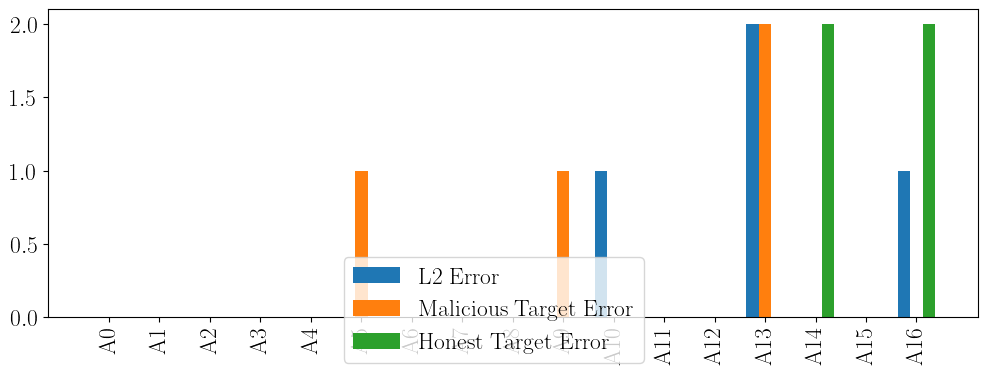

In [40]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
x = np.arange(0, len(attack), 1)
ax.bar(x, L[:, 0], width = 0.25, label = 'L2 Error')
ax.bar(x + .25, L[:, 1], width = 0.25, label = 'Malicious Target Error')
ax.bar(x + 0.5, L[:, 2], width = 0.25, label = 'Honest Target Error')
ax.set_xticks(x+0.25, [attack_names_short[a] for a in attack_names], rotation=90)
fig.legend(loc='outside lower center')
#ax.set_xticklabels(attack)

In [171]:
attack_names_short

{'Inf 1 Rand': 'A0',
 'Def 1 Rand': 'A1',
 'Inf 1 Friend': 'A2',
 'Def 1 Friend': 'A3',
 'Inf 5 Rand': 'A4',
 'Inf 20 Rand': 'A5',
 'Def 5 Comm': 'A6',
 'Def 20 Comm': 'A7',
 'Inf+Def 5 Comm': 'A8',
 'Inf+Def 20 Comm': 'A9',
 '2 Inf 5 Comm': 'A10',
 '2 Def 5 Comm': 'A11',
 'Inf 5 Def 5 Comm': 'A12',
 '2 Inf 20 Comm': 'A13',
 '2 Def 20 Comm': 'A14',
 'Inf 20 Def 20 Comm': 'A15',
 'Def Big Comm': 'A16'}

## Evalutating flagging data

In [41]:
D0 = pd.DataFrame(df)
D2 = pd.DataFrame(df_gnp)

In [42]:
df_total = pd.concat((D0, D2))

In [43]:
df_nan = df_total[['Graph', 'Protocol', 'Attack', 'Attack Strength', 'Mal T Nan', 'Mal Nan', 'Mal T Tot']]
df_nan = df_nan.groupby(['Graph', 'Protocol', 'Attack', 'Attack Strength']).mean()
#df_nan.columns = df_nan.columns.get_level_values(0)
df_nan.loc[:, 'Mal T Nan Pct'] = df_nan.loc[:, 'Mal T Nan'] / df_nan.loc[:, 'Mal T Tot']
df_nan.loc[:, 'Mal Nan Pct'] = df_nan.loc[:, 'Mal Nan'] / (40 - df_nan.loc[:, 'Mal T Tot'])

In [44]:
inf_df_nan = df_nan.loc[df_nan.loc[:, 'Mal T Tot'] > 0, :]

In [45]:
inf_df_nan.groupby(['Graph', 'Protocol', 'Attack Strength']).agg(["mean", "min", "max"])

Mal T Nan              Mal Nan  \
                                                mean   min    max    mean   
Graph Protocol             Attack Strength                                  
FB    Naive, Response      strong              0.000  0.00   0.00     0.0   
      RR+Laplace, Response strong              4.970  0.55  10.90     0.0   
      RR, Response         strong              4.970  0.70  11.80     0.0   
GNP   Naive, Response      strong              0.000  0.00   0.00     0.0   
      RR+Laplace, Response strong              4.740  0.55  10.20     0.0   
      RR, Response         strong              4.835  0.65  10.65     0.0   

                                                     Mal T Tot             \
                                            min  max      mean  min   max   
Graph Protocol             Attack Strength                                  
FB    Naive, Response      strong           0.0  0.0       8.2  1.0  20.0   
      RR+Laplace, Response strong           0.0  0.0       8.2  1.0  20.0   
      RR, Response         strong           0.0  0.0       8.2  1.0  20.0   
GNP   Naive, Response      strong           0.0  0.0       8.2  1.0  20.0   
      RR+Laplace, Response strong           0.0  0.0       8.2  1.0  20.0   
      RR, Response         strong           0.0  0.0       8.2  1.0  20.0   

                                           Mal T Nan Pct               \
                                                    mean    min   max   
Graph Protocol             Attack Strength                              
FB    Naive, Response      strong               0.000000  0.000  0.00   
      RR+Laplace, Response strong               0.621167  0.545  0.70   
      RR, Response         strong               0.632250  0.560  0.75   
GNP   Naive, Response      strong               0.000000  0.000  0.00   
      RR+Laplace, Response strong               0.598583  0.510  0.70   
      RR, Response         strong               0.614417  0.520  0.70   

                                           Mal Nan Pct            
                                                  mean  min  max  
Graph Protocol             Attack Strength                        
FB    Naive, Response      strong                  0.0  0.0  0.0  
      RR+Laplace, Response strong                  0.0  0.0  0.0  
      RR, Response         strong                  0.0  0.0  0.0  
GNP   Naive, Response      strong                  0.0  0.0  0.0  
      RR+Laplace, Response strong                  0.0  0.0  0.0  
      RR, Response         strong                  0.0  0.0  0.0

In [46]:
inf_df_nan = df_nan.loc[df_nan.loc[:, 'Mal Nan Pct'] > 0, :]

In [47]:
inf_df_nan.groupby(['Graph', 'Protocol', 'Attack Strength']).agg(["mean", "min", "max"])

Mal T Nan           Mal Nan         \
                                                mean  min  max    mean    min   
Graph Protocol             Attack Strength                                      
FB    RR+Laplace, Response strong                0.0  0.0  0.0    1.80   1.80   
      RR, Response         strong                0.0  0.0  0.0    1.20   1.20   
GNP   RR+Laplace, Response strong                0.0  0.0  0.0   38.70  38.70   
      RR, Response         strong                0.0  0.0  0.0   39.55  39.55   

                                                  Mal T Tot            \
                                              max      mean  min  max   
Graph Protocol             Attack Strength                              
FB    RR+Laplace, Response strong            1.80       0.0  0.0  0.0   
      RR, Response         strong            1.20       0.0  0.0  0.0   
GNP   RR+Laplace, Response strong           38.70       0.0  0.0  0.0   
      RR, Response         strong           39.55       0.0  0.0  0.0   

                                           Mal T Nan Pct         Mal Nan Pct  \
                                                    mean min max        mean   
Graph Protocol             Attack Strength                                     
FB    RR+Laplace, Response strong                    NaN NaN NaN     0.04500   
      RR, Response         strong                    NaN NaN NaN     0.03000   
GNP   RR+Laplace, Response strong                    NaN NaN NaN     0.96750   
      RR, Response         strong                    NaN NaN NaN     0.98875   

                                                              
                                                min      max  
Graph Protocol             Attack Strength                    
FB    RR+Laplace, Response strong           0.04500  0.04500  
      RR, Response         strong           0.03000  0.03000  
GNP   RR+Laplace, Response strong           0.96750  0.96750  
      RR, Response         strong           0.98875  0.98875

In [48]:
df_nan2 = df_total[['Protocol', 'Attack', 'Attack Strength', 'Graph', 'Mal T Nan', 'Mal Nan', 'Mal T Tot']]

In [49]:
df_nan2 = df_nan2.groupby(['Protocol', 'Attack', 'Attack Strength', 'Graph']).mean()

In [50]:
df_nan2[df_nan2['Mal Nan'] > 0]

Mal T Nan  Mal Nan  \
Protocol             Attack       Attack Strength Graph                       
RR+Laplace, Response Def Big Comm strong          FB           0.0     1.80   
                                                  GNP          0.0    38.70   
RR, Response         Def Big Comm strong          FB           0.0     1.20   
                                                  GNP          0.0    39.55   

                                                         Mal T Tot  
Protocol             Attack       Attack Strength Graph             
RR+Laplace, Response Def Big Comm strong          FB           0.0  
                                                  GNP          0.0  
RR, Response         Def Big Comm strong          FB           0.0  
                                                  GNP          0.0

# Evaluating effect of number of malicious users on error metrics

In [51]:
gnm_inc_asymp = 2052
fb_inc_asymp = 153
gnm_dec_asymp = 27
fb_dec_asymp = 84

In [52]:
thresh_values = {'med': (0.9, 0.5, 0.5)}
attack_values = {'strong': (0.17, 0.17)}

In [53]:
def collect_data_new(attack_names, g, g_name, max_adv, epsilons, thresh_values, attack_values, comm, reps):
    labels = ['RR+Laplace, Response', 'RR+Laplace, Input', 'RR, Response', 'RR, Input', 'Naive, Response', 'Naive, Input']
    E = [experiments.ResponseLaplaceManipulation(g, max_adv, 1.0, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]), 
         experiments.InputLaplaceManipulation(g, max_adv, 1.0, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]),
         experiments.ResponseRRManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         experiments.InputRRManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         experiments.ResponseRRNaiveManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         experiments.InputRRNaiveManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5])
        ]
    data = []
    max_adv = (g.get_dim() * np.array(max_adv)).astype(int)
    for x in range(0, reps):
        for n_mal in max_adv:
            t2 = int(n_mal // 6)
            if attack_names[0] == 'Inf+Def Comm':
                attacks = [ [(t2, t2, n_mal-t2, list(comm))] ]
            elif attack_names[0] == '2 Inf Comm':
                attacks = [ [(t2, 0, n_mal // 2 - t2, list(comm)), (t2, 0, n_mal // 2 - t2, list(comm))] ]
            else:
                assert False
            #pdb.set_trace()
            for epsilon in epsilons:
                for exp in E:
                    exp.set_epsilon(epsilon)
                    exp.max_num_mal = n_mal
                for a_i in range(0, len(attacks)):
                    for i in range(0, len(E)):
                        E[i].reset_attacks()
                    E[0].add_attacks(attacks[a_i])
                    for i in range(1, len(E)):
                        E[i].set_attacks_like(E[0])

                    for av in attack_values.keys():
                        for tv in thresh_values.keys():
                            for i in range(0, len(E)):
                                E[i].threshold_reduction = thresh_values[tv]
                                if 'Naive' in labels[i]:
                                    E[i].inflation_factors = (1.0,)
                                else:
                                    E[i].inflation_factors = attack_values[av] 
                                d = E[i].get_results(False)
                                h = {'Protocol': labels[i], 'Attack': attack_names[a_i], 'Attack Strength': av, 'Threshold Strength': tv, 'Eps': epsilon, 'Graph': g_name,
                                    'Mal Max Error': d[0][0], 'Mal L2 Error': d[0][1], 'Mal Mean Error': d[0][2], 'Mal T Nan': d[1][0], 'Mal T Tot': d[1][1], 'Mal Nan': d[2],
                                    'Num Mal': n_mal, 'Hon T Max Error': d[3][0], 'Hon T L2 Error': d[3][1], 'Hon T Mean Error': d[3][2], 'Hon T Nan': d[4][0], 'Hon T Tot': d[4][1],
                                    'Rest Max Error': d[5][0], 'Rest L2 Error': d[5][1], 'Rest Mean Error': d[5][2], 'Rest Nan': d[6][0], 'Rest Tot': d[6][1]
                                }
                                data.append(h)
    return data

In [54]:
#data_vary_n_mal = collect_data_new(['Inf+Def Comm'], g, 'FB', [0.01, 0.02, 0.03, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.33], [0.7], thresh_values, attack_values, list(comms[1]) + list(comms[0]), 15)
#data_vary_n_mal_gnp = collect_data_new(['Inf+Def Comm'], gnp, 'GNP', [0.01, 0.02, 0.03, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.33], [0.7], thresh_values, attack_values, list(comms[1]) + list(comms[0]), 15)

In [55]:
#pickle.dump((data_vary_n_mal, data_vary_n_mal_gnp), open('df_vary.pkl', 'wb'))

In [56]:
data_vary_n_mal, data_vary_n_mal_gnp = pickle.load(open('df_vary.pkl', 'rb'))

In [57]:
DF = pd.concat((pd.DataFrame(data_vary_n_mal), pd.DataFrame(data_vary_n_mal_gnp)))
DF = DF.drop(['Attack Strength', 'Threshold Strength', 'Eps'], axis=1)

In [58]:
DF = DF.groupby(['Protocol', 'Attack', 'Graph', 'Num Mal']).mean()

In [59]:
DF.index.get_level_values(3)

Index([  40,   80,  121,  201,  403,  605,  807, 1009, 1211, 1332,
       ...
         40,   80,  120,  200,  400,  600,  800, 1000, 1200, 1320],
      dtype='int64', name='Num Mal', length=120)

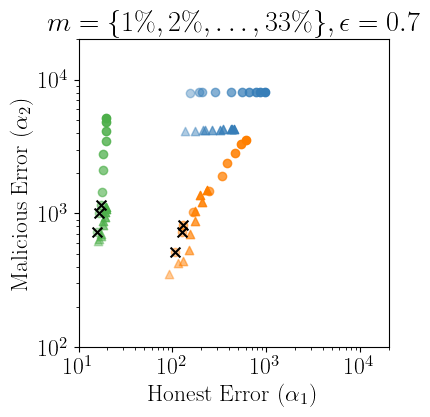

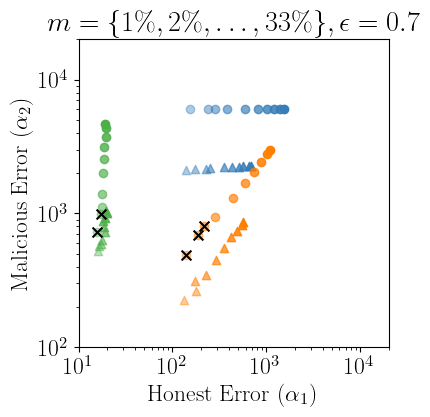

In [60]:
matplotlib.rcParams['figure.figsize'] = (4.0,4.0)
def do_nmal_plot(DF, graph, width, height, name):
    fig, ax = plt.subplots()
    P = DF.loc[:, 'Inf+Def Comm', graph, :]
    n_nodes = 4000
    colors = [CB_color_cycle[0], CB_color_cycle[0], CB_color_cycle[2], CB_color_cycle[2], CB_color_cycle[1], CB_color_cycle[1]]
    markers = ['^', 'o', '^', 'o', '^', 'o']
    att_names = list( P.index.get_level_values(0).unique() )
    for i in range(0, len(att_names)):
        Q = P.loc[att_names[i], :]
        x = Q['Hon T Max Error']
        y = Q['Mal Max Error']
        nan = Q['Mal T Nan']
        alphas = np.linspace(0.4, 1.0, len(x))
        for j in range(0, len(x)):
            ax.scatter(Q['Hon T Max Error'].iloc[j], Q['Mal Max Error'].iloc[j], c=colors[i], marker=markers[i], alpha = alphas[j])
            if nan.iloc[j] > 0:
                ax.scatter(Q['Hon T Max Error'].iloc[j], Q['Mal Max Error'].iloc[j], c='k', marker='x', zorder=5, s=50)

    #ax.plot((0, width), (height, height), color='#f781bf', linewidth=1.5)
    #ax.plot((width, width), (height, 0), color='#f781bf', linewidth=1.5)
    #ax.hlines(height, 0, 5*n_nodes, color='#f781bf', linestyle='dotted')
    #ax.vlines(width, 0, 5*n_nodes, color='#f781bf', linestyle='dotted')
    ax.set_xlabel(r'Honest Error $(\alpha_1)$')
    ax.set_ylabel(r'Malicious Error $(\alpha_2)$')
    ax.set_yscale('log')
    ax.set_ylim([100, 5*n_nodes])
    ax.set_xlim([10, 5*n_nodes])
    ax.set_xscale('log')
    ax.set_title(r'$m = \{1\%, 2\%, \ldots, 33\%\}, \epsilon = 0.7$')
    #ax.annotate(r'$$d_{95}$$', (2.5*n_nodes, height * 1.2), fontsize=16)
    #ax.annotate(r'$$d_{95}-d_{80}$$', (1.2*width, 3.5*n_nodes), fontsize=16)
    plt.savefig(name, bbox_inches = "tight")
    #Add asymptote for naive.
do_nmal_plot(DF, 'FB', fb_dec_asymp, fb_inc_asymp, path+'fb_inf_vary_nmal.pdf')
do_nmal_plot(DF, 'GNP', gnm_dec_asymp, gnm_inc_asymp, path+'gnp_inf_vary_nmal.pdf')

In [61]:
print( DF.loc['RR, Response', :, 'FB', 1332]['Hon T Max Error'] / DF.loc['RR, Response', :, 'FB', 40]['Hon T Max Error'])

Attack
Inf+Def Comm    5.810803
Name: Hon T Max Error, dtype: float64


In [62]:
print( DF.loc['RR, Response', :, 'GNP', 1320]['Hon T Max Error'] / DF.loc['RR, Response', :, 'GNP', 40]['Hon T Max Error'])

Attack
Inf+Def Comm    7.85631
Name: Hon T Max Error, dtype: float64


# Evaluating effect of epsilon on error rates

In [63]:
#data_vary_eps = collect_data_new(['Inf+Def Comm'], g, 'FB', [0.01], [0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0], thresh_values, attack_values, list(comms[1]), 10)
#data_vary_eps_gnp = collect_data_new(['Inf+Def Comm'], g, 'GNP', [0.01], [0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0], thresh_values, attack_values, comms_gnp, 10)

In [64]:
#pickle.dump((data_vary_eps, data_vary_eps_gnp), open('df_vary_eps.pkl', 'wb'))

In [65]:
data_vary_eps, data_vary_eps_gnp = pickle.load(open('df_vary_eps.pkl', 'rb'))

In [66]:
DF2 = pd.concat(( pd.DataFrame(data_vary_eps), pd.DataFrame(data_vary_eps_gnp) ))

In [67]:
DF2 = DF2.drop(['Threshold Strength', 'Attack Strength'], axis=1)

In [68]:
DF2 = DF2.groupby(['Protocol', 'Attack', 'Graph', 'Eps']).mean()

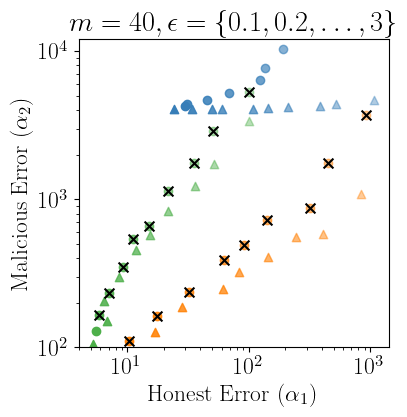

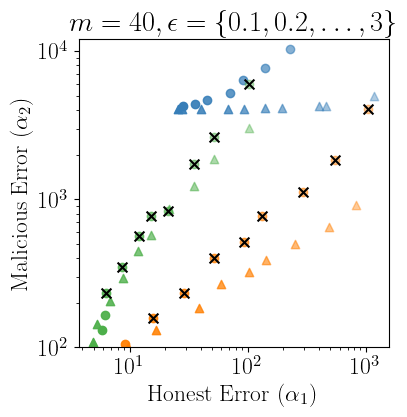

In [69]:
def do_eps_plot(DF, graph, width, height, name):
    fig, ax = plt.subplots()
    P = DF.loc[:, 'Inf+Def Comm', graph, :]
    n_nodes = 4000
    colors = [CB_color_cycle[0], CB_color_cycle[0], CB_color_cycle[2], CB_color_cycle[2], CB_color_cycle[1], CB_color_cycle[1]]
    markers = ['^', 'o', '^', 'o', '^', 'o']
    att_names = list( P.index.get_level_values(0).unique() )
    for i in range(0, len(att_names)):
        Q = P.loc[att_names[i], :]
        x = Q['Hon T Max Error']
        y = Q['Mal Max Error']
        alphas = np.linspace(0.4, 1.0, len(x))
        nan = Q['Mal T Nan']
        for j in range(0, len(x)):
            ax.scatter(Q['Hon T Max Error'].iloc[j], Q['Mal Max Error'].iloc[j], c=colors[i], marker=markers[i], alpha=alphas[j])
            if nan.iloc[j] > 0:
                ax.scatter(Q['Hon T Max Error'].iloc[j], Q['Mal Max Error'].iloc[j], c='k', marker='x', zorder=5, s=50)

    #ax.plot((0, width), (height, height), color='#f781bf', linewidth=1.5)
    #ax.plot((width, width), (height, 0), color='#f781bf', linewidth=1.5)
    #ax.hlines(height, 0, 10*n_nodes, color='#f781bf', linestyle='dotted')
    #ax.vlines(width, 0, 10*n_nodes, color='#f781bf', linestyle='dotted')
    ax.set_xlabel(r'Honest Error $(\alpha_1)$')
    ax.set_ylabel(r'Malicious Error $(\alpha_2)$')
    ax.set_yscale('log')
    ax.set_ylim([100, 3*n_nodes])
    #ax.set_xlim([1, 1500])
    ax.set_xscale('log')
    ax.set_title(r'$m = 40, \epsilon = \{0.1, 0.2, \ldots, 3\}$')
    plt.savefig(name, bbox_inches = "tight")
    
do_eps_plot(DF2, 'FB', fb_dec_asymp, fb_inc_asymp, path+'fb_inf_vary_eps.pdf')
do_eps_plot(DF2, 'GNP', gnm_dec_asymp, gnm_inc_asymp, path+'gnp_inf_vary_eps.pdf')

In [70]:
print( DF2.loc['RR, Response', :, 'FB', 0.1]['Mal Max Error'] / DF2.loc['RR, Response', :, 'FB', 3.0]['Mal Max Error'] )

Attack
Inf+Def Comm    45.648196
Name: Mal Max Error, dtype: float64


# TPR vs FPR for Varying Threshold.

In [214]:
def collect_data_thresh(attack_names, g, g_name, max_adv, epsilons, thresh, thresh_ratios, attack_values, comm, reps):
    labels = ['RR+Laplace, Response', 
              #'RR+Laplace, Input', 
              'RR, Response', 
              #'RR, Input', 
              'Naive, Response' 
              #'Naive, Input'
             ]
    E = [experiments.ResponseLaplaceManipulation(g, max_adv, 1.0, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]), 
         #experiments.InputLaplaceManipulation(g, max_adv, 1.0, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]),
         experiments.ResponseRRManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         #experiments.InputRRManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         experiments.ResponseRRNaiveManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         #experiments.InputRRNaiveManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5])
        ]
    data = []
    max_adv = (g.get_dim() * np.array(max_adv)).astype(int)
    for x in range(0, reps):
        for n_mal in max_adv:
            t2 = int(n_mal // 6)
            if attack_names[0] == 'Inf+Def Comm':
                attacks = [ [(t2, t2, n_mal-t2, list(comm))] ]
            elif attack_names[0] == '2 Inf Comm':
                attacks = [ [(t2, 0, n_mal // 2 - t2, list(comm)), (t2, 0, n_mal // 2 - t2, list(comm))] ]
            else:
                assert False
            #pdb.set_trace()
            for epsilon in epsilons:
                for exp in E:
                    exp.set_epsilon(epsilon)
                    exp.max_num_mal = n_mal
                for a_i in range(0, len(attacks)):
                    for i in range(0, len(E)):
                        E[i].reset_attacks()
                    E[0].add_attacks(attacks[a_i])
                    for i in range(1, len(E)):
                        E[i].set_attacks_like(E[0])

                    for av in attack_values.keys():
                        for tr in thresh_ratios:
                            for i in range(0, len(E)):
                                E[i].threshold_reduction = tr * thresh
                                E[i].num_flag = int(0.05 * g.get_size() * (2*tr-1))
                                E[i].inflation_factors = attack_values[av]
                                d = E[i].get_results(False)
                                h = {'Protocol': labels[i], 'Attack': attack_names[a_i], 'Attack Strength': av, 'Threshold Strength': tr, 'Eps': epsilon, 'Graph': g_name,
                                    'Mal Max Error': d[0][0], 'Mal L2 Error': d[0][1], 'Mal Mean Error': d[0][2], 'Mal T Nan': d[1][0], 'Mal T Tot': d[1][1], 'Mal Nan': d[2],
                                    'Num Mal': n_mal, 'Hon T Max Error': d[3][0], 'Hon T L2 Error': d[3][1], 'Hon T Mean Error': d[3][2], 'Hon T Nan': d[4][0], 'Hon T Tot': d[4][1],
                                    'Rest Max Error': d[5][0], 'Rest L2 Error': d[5][1], 'Rest Mean Error': d[5][2], 'Rest Nan': d[6][0], 'Rest Tot': d[6][1]
                                }
                                data.append(h)
    return data

In [86]:
attack_values_t = {'med': (0.17/2, 0.17/2)}
data_vary_thresh = collect_data_thresh(['2 Inf Comm'], g, 'FB', [0.01], [0.7], np.array([0.9, 0.5, 0.5]), np.linspace(0.55, 1.0, 10), attack_values_t, list(comms[1]), 10)
data_vary_thresh_gnp = collect_data_thresh(['2 Inf Comm'], gnp, 'GNP', [0.01], [0.7], np.array([0.9, 0.5, 0.5]), np.linspace(0.55, 1.0, 10), attack_values_t, list(comms[1]), 10)

In [87]:
pickle.dump((data_vary_thresh, data_vary_thresh_gnp), open('df_vary_thresh.pkl', 'wb'))

In [88]:
DF3 = pd.concat(( pd.DataFrame(data_vary_thresh), pd.DataFrame(data_vary_thresh_gnp) ))

In [89]:
DF3 = DF3.drop(['Attack Strength'], axis=1)

In [90]:
DF3 = DF3.groupby(['Protocol', 'Attack', 'Graph', 'Threshold Strength']).mean()

In [91]:
# Honest users flagged vs % malicious users flagged scatter plot.
DF3.loc['RR, Response', '2 Inf Comm', 'FB', :]

,Eps,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,Mal T Tot,Mal Nan,Num Mal,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot
Threshold Strength,,,,,,,,,,,,,,,,,,
0.55,0.7,255.100049,315.755732,229.004509,10.1,12.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,233.265036,3691.780207,47.646827,171.7,3999.0
0.60,0.7,263.896470,400.897941,222.509139,9.1,12.0,0.5,40.0,0.0,0.0,0.0,0.0,0.0,218.835191,3716.817189,47.402144,82.3,3999.0
0.65,0.7,335.377941,560.861283,258.175027,7.4,12.0,0.1,40.0,0.0,0.0,0.0,0.0,0.0,224.341180,3749.962718,47.466558,29.4,3999.0
0.70,0.7,314.937632,613.509725,240.140572,5.7,12.0,0.1,40.0,0.0,0.0,0.0,0.0,0.0,227.291996,3736.589105,47.256601,9.5,3999.0
0.75,0.7,366.885302,809.147231,263.470488,3.0,12.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,226.141742,3768.826928,47.610424,2.9,3999.0
0.80,0.7,332.818639,781.137708,250.125108,2.6,12.0,0.1,40.0,0.0,0.0,0.0,0.0,0.0,226.397638,3771.025102,47.594763,0.6,3999.0
0.85,0.7,357.885691,884.015420,257.407769,0.9,12.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,223.449968,3772.941700,47.600223,0.1,3999.0
0.90,0.7,361.052743,864.841416,248.646000,0.6,12.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,221.371242,3753.380592,47.335362,0.0,3999.0
0.95,0.7,372.547317,960.491040,271.637598,0.1,12.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,225.316934,3772.555072,47.544290,0.0,3999.0


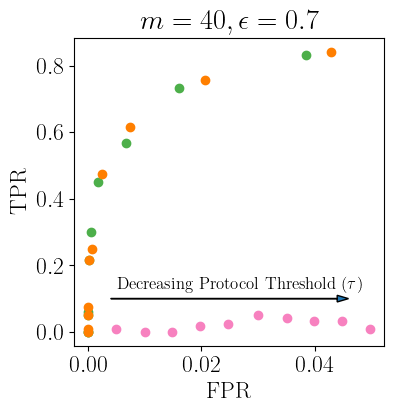

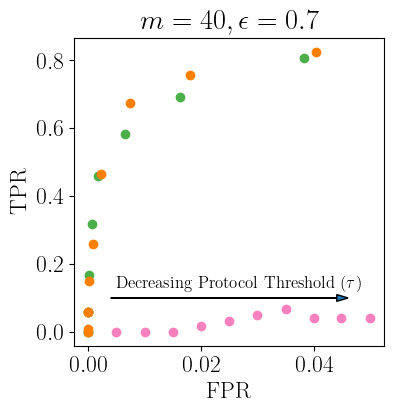

In [659]:
def do_thresh_plot(DF3, graph, name):
    fig, ax = plt.subplots(figsize=(4,4))
    P = DF3.loc[:, '2 Inf Comm', graph, :]
    colors = [CB_color_cycle[2], CB_color_cycle[1], CB_color_cycle[3]]
    markers = ['o', 'o', 'o']
    att_names = ['RR+Laplace, Response', 'RR, Response', 'Naive, Response']
    for i in range(0, len(att_names)):
        Q = P.loc[att_names[i], :]
        x = Q['Rest Nan'] / Q['Rest Tot']
        y = Q['Mal T Nan'] / Q['Mal T Tot']
        alphas = np.linspace(0.4, 1.0, len(x))
        for j in range(0, len(x)):
            ax.scatter(x.iloc[j], y.iloc[j], color=colors[i], marker=markers[i])
        #pdb.set_trace()
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title(r'$m = 40, \epsilon = 0.7$')
    ax.arrow(0.004, 0.1, 0.04, 0, head_length=0.002, head_width=0.02)
    ax.annotate(r'Decreasing Protocol Threshold ($\tau$)', (0.005, 0.13), rotation=0, size=12)
    plt.savefig(name, bbox_inches='tight')
"""
    P1 = DF3.loc['Naive, Response', '2 Inf Comm', 'FB', :]
    ax.scatter(P1['Mal T Nan'] / P1['Mal T Tot'], P1['Rest Nan'] / P1['Rest Tot'])
    P2 = DF3.loc['RR, Response', '2 Inf Comm', 'FB', :]
    ax.scatter(P2['Mal T Nan'] / P2['Mal T Tot'], P2['Rest Nan'] / P2['Rest Tot'])
    P3 = DF3.loc['RR+Laplace, Response', '2 Inf Comm', 'FB', :]
    ax.scatter(P3['Mal T Nan'] / P3['Mal T Tot'], P3['Rest Nan'] / P3['Rest Tot'])

    plt.savefig(path+'thresh_scatter.pdf')
"""
do_thresh_plot(DF3, 'FB', path+'fb_inf_vary_thresh.pdf')
do_thresh_plot(DF3, 'GNP', path+'gnp_inf_vary_thresh.pdf')

# Comparing Input Vs Response on Strongest Possible Attacks

In [93]:
def collect_data_ir(attack_names, g, g_name, max_adv, epsilons, thresh_values, attack_values, comm, reps):
    labels = ['RR+Laplace, Response', 'RR+Laplace, Input', 'RR, Response', 'RR, Input', 'Naive, Response', 'Naive, Input']
    E = [experiments.ResponseLaplaceManipulation(g, max_adv, 1.0, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]), 
         experiments.InputLaplaceManipulation(g, max_adv, 1.0, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]),
         experiments.ResponseRRManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         experiments.InputRRManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         experiments.ResponseRRNaiveManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         experiments.InputRRNaiveManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5])
        ]
    
    data = []
    max_adv = (g.get_dim() * np.array(max_adv)).astype(int)
    for x in range(0, reps):
        for n_mal in max_adv:
            t2 = int(n_mal // 6)
            attacks = [ [(t2, t2, n_mal-t2, list(comm))] ]
            for epsilon in epsilons:
                for exp in E:
                    exp.set_epsilon(epsilon)
                    exp.max_num_mal = n_mal
                for a_i in range(0, len(attacks)):
                    for i in range(0, len(E)):
                        E[i].reset_attacks()
                    E[0].add_attacks(attacks[a_i])
                    for i in range(1, len(E)):
                        E[i].set_attacks_like(E[0])

                    for av in attack_values.keys():
                        for tv in thresh_values.keys():
                            for i in range(0, len(E)):
                                #Naive always worst attack
                                if 'Naive' in labels[i]:
                                    E[i].inflation_factors = (1.0,)
                                else:
                                    E[i].inflation_factors = attack_values[av]
                                E[i].threshold_reduction = thresh_values[tv]
                                d = E[i].get_results(False)
                                h = {'Protocol': labels[i], 'Attack': attack_names[a_i], 'Attack Strength': av, 'Threshold Strength': tv, 'Eps': epsilon, 'Graph': g_name,
                                    'Mal Max Error': d[0][0], 'Mal L2 Error': d[0][1], 'Mal Mean Error': d[0][2], 'Mal T Nan': d[1][0], 'Mal T Tot': d[1][1], 'Mal Nan': d[2],
                                    'Num Mal': n_mal, 'Hon T Max Error': d[3][0], 'Hon T L2 Error': d[3][1], 'Hon T Mean Error': d[3][2], 'Hon T Nan': d[4][0], 'Hon T Tot': d[4][1],
                                    'Rest Max Error': d[5][0], 'Rest L2 Error': d[5][1], 'Rest Mean Error': d[5][2], 'Rest Nan': d[6][0], 'Rest Tot': d[6][1]
                                }
                                data.append(h)
    return data

In [154]:
#data_ir = collect_data_ir(['Inf+Def Comm'], g, 'FB', [0.01], [0.7, 3.0], {'med': (0.9, 0.5, 0.5)}, {'strong': (0.17, 0.17)}, list(comms[1]) + list(comms[0]), 10)
#data_ir2 = collect_data_ir(['Inf+Def Comm'], g, 'FB', [0.33], [0.7, 3.0], {'med': (0.3, 0.2, 0.2)}, {'strong': (0.3, 0.3)}, list(comms[1]) + list(comms[0]), 10)

In [155]:
#pickle.dump((data_ir, data_ir2), open('df4.pkl', 'wb'))
data_ir, data_ir2 = pickle.load(open('df4.pkl', 'rb'))
df_ir = pd.concat((pd.DataFrame(data_ir), pd.DataFrame(data_ir2)))

In [163]:
#data_ir_gnp = collect_data_ir(['Inf+Def Comm'], gnp, 'GNP', [0.01], [0.7, 3.0], {'med': (0.9, 0.5, 0.5)}, {'strong': (0.17, 0.17)}, list(comms[1]) + list(comms[0]), 10)
#data_ir2_gnp = collect_data_ir(['Inf+Def Comm'], gnp, 'GNP', [0.33], [0.7, 3.0], {'med': (0.3, 0.2, 0.2)}, {'strong': (0.3, 0.3)}, list(comms[1]) + list(comms[0]), 10)

In [164]:
#pickle.dump((data_ir_gnp, data_ir2_gnp), open('df5.pkl', 'wb'))
data_ir_gnp, data_ir2_gnp = pickle.load(open('df5.pkl', 'rb'))
df_ir_gnp = pd.concat( (pd.DataFrame(data_ir_gnp), pd.DataFrame(data_ir2_gnp) ))

In [165]:
df_ir = df_ir.groupby(['Protocol', 'Attack', 'Attack Strength', 'Threshold Strength', 'Graph', 'Eps', 'Num Mal']).mean()
df_ir_gnp = df_ir_gnp.groupby(['Protocol', 'Attack', 'Attack Strength', 'Threshold Strength', 'Graph', 'Eps', 'Num Mal']).mean()

In [167]:
def do_plot(df_ir, eps, graph, n_mal, name, width, height, arrow = 0):
    P = df_ir.loc[:, 'Inf+Def Comm', 'strong', 'med', graph, eps, n_mal]
    #pdb.set_trace()
    names = list(P.index)
    n_nodes = 4000
    fig, ax = plt.subplots(figsize=(4.0, 4.0))
    markers = {'RR+Laplace, Response':'o', 'RR+Laplace, Input':'^', 'RR, Response':'o',
               'RR, Input':'^', 'Naive, Response':'o', 'Naive, Input':'^'}
    colors = {'RR+Laplace, Response': CB_color_cycle[2], 'RR+Laplace, Input':CB_color_cycle[2], 
              'RR, Response':CB_color_cycle[1], 'RR, Input':CB_color_cycle[1],
              'Naive, Response':CB_color_cycle[0], 'Naive, Input':CB_color_cycle[0]}
    for k in markers.keys():
        ax.scatter( P.loc[:, 'Hon T Max Error'][k], P.loc[:, 'Mal Max Error'][k], c = colors[k], marker = markers[k])
        #pdb.set_trace()
        if P.loc[:, 'Mal T Nan'][k] > 0:
            ax.scatter( P.loc[:, 'Hon T Max Error'][k], P.loc[:, 'Mal Max Error'][k], c='k', marker='x', zorder=5, s=50)
    ax.plot((0, width), (height, height), color='#f781bf', linewidth=1.5)
    ax.plot((width, width), (height, 0), color='#f781bf', linewidth=1.5)
    ax.hlines(height, 0, 10*n_nodes, color='#f781bf', linestyle='dotted')
    ax.vlines(width, 0, 10*n_nodes, color='#f781bf', linestyle='dotted')
    ax.set_xlim([1, 10*n_nodes])
    ax.set_xscale('log')
    ax.set_xlabel(r'Honest Error $(\alpha_1)$')
    ax.set_ylim([1, 10*n_nodes])
    ax.set_yscale('log')
    ax.set_ylabel(r'Malicious Error $(\alpha_2)$')
    ax.set_title('$\\epsilon=%0.2f, m=%d$' % (eps, n_mal))
    if arrow == 1:
        ax.arrow(3, 2, 0, 5000, head_length=3000, head_width=1)
        ax.annotate('Increasing malicious error', (1.3,2), rotation=90)
    elif arrow == -1:
        ax.arrow(2, 2, 5000, 0, head_length=3000, head_width=1)
        ax.annotate('Increasing honest error', (2, 2.8), rotation=0)
    else:
        ax.annotate(r'$$d_{95}$$', (1.3, height*0.5), fontsize=16)
        ax.annotate(r'$$d_{95}-d_{80}$$', (width*1.3, 2), fontsize=16)
    plt.savefig(path+name, bbox_inches = "tight")

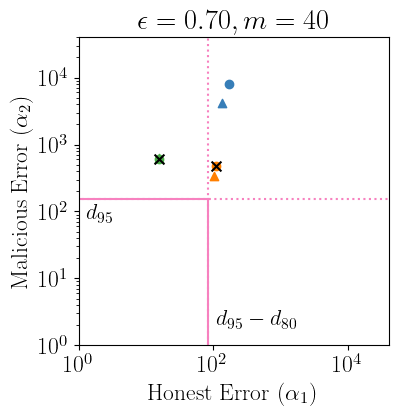

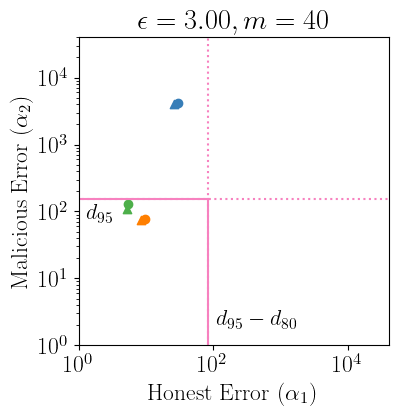

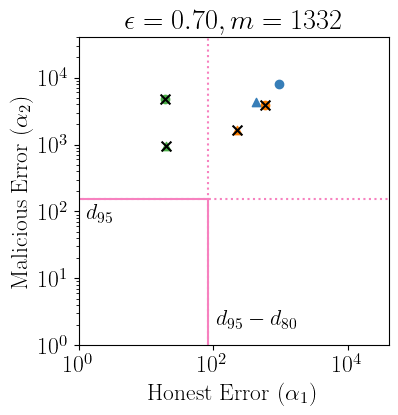

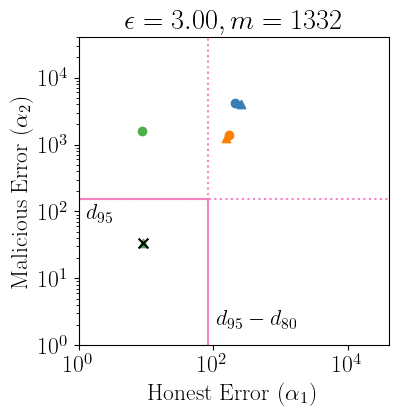

In [168]:
do_plot(df_ir, 0.7, 'FB', 40, 'fb_lowEps_lowM.pdf', fb_dec_asymp, fb_inc_asymp)
do_plot(df_ir, 3.0, 'FB', 40, 'fb_hiEps_lowM.pdf', fb_dec_asymp, fb_inc_asymp)
do_plot(df_ir, 0.7, 'FB', 1332, 'fb_lowEps_hiM.pdf', fb_dec_asymp, fb_inc_asymp)
do_plot(df_ir, 3.0, 'FB', 1332, 'fb_hiEps_hiM.pdf', fb_dec_asymp, fb_inc_asymp)

In [169]:
print( df_ir.loc['RR+Laplace, Response', :, :, :, :, 0.7, 1332]['Mal Max Error'] / df_ir.loc['RR+Laplace, Input', :, :, :, :, 0.7, 1332]['Mal Max Error'] )
print( df_ir.loc['RR, Response', :, :, :, :, 0.7, 1332]['Hon T Max Error'] / df_ir.loc['RR, Input', :, :, :, :, 0.7, 1332]['Hon T Max Error'] )

Attack        Attack Strength  Threshold Strength  Graph
Inf+Def Comm  strong           med                 FB       5.145979
Name: Mal Max Error, dtype: float64
Attack        Attack Strength  Threshold Strength  Graph
Inf+Def Comm  strong           med                 FB       2.605368
Name: Hon T Max Error, dtype: float64


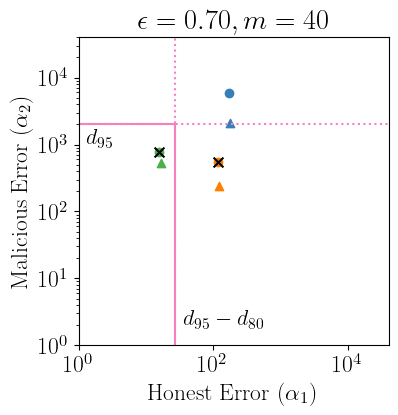

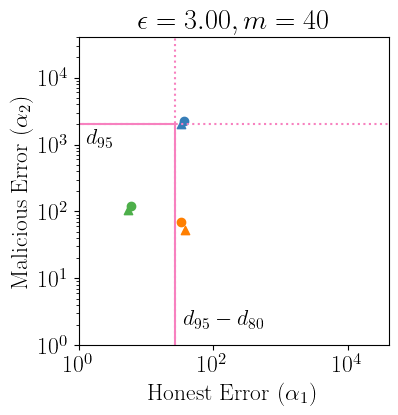

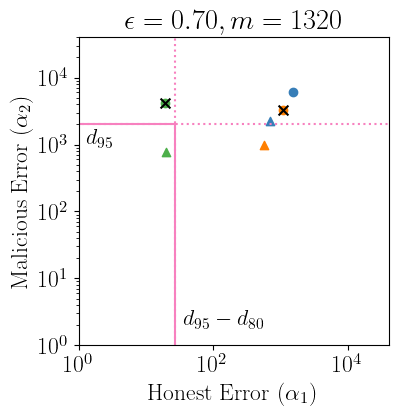

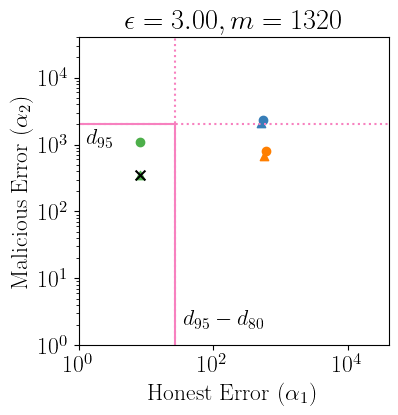

In [170]:
do_plot(df_ir_gnp, 0.7, 'GNP', 40, 'gnp_lowEps_lowM.pdf', gnm_dec_asymp, gnm_inc_asymp)
do_plot(df_ir_gnp, 3.0, 'GNP', 40, 'gnp_hiEps_lowM.pdf', gnm_dec_asymp, gnm_inc_asymp)
do_plot(df_ir_gnp, 0.7, 'GNP', 1320, 'gnp_lowEps_hiM.pdf', gnm_dec_asymp, gnm_inc_asymp)
do_plot(df_ir_gnp, 3.0, 'GNP', 1320, 'gnp_hiEps_hiM.pdf', gnm_dec_asymp, gnm_inc_asymp)

# Adaptive poisoning experiments

In [608]:
#Make a plot of probability of failure vs 'normalized' malicious error threshold
attack_values_p = {t: (t*0.25, t*0.25) for t in np.linspace(0.2, 1, 20)}
df_poi = collect_data_thresh(['2 Inf Comm'], g, 'FB', [0.01], [0.7], np.array((0.9, 0.5, 0.5)), [1.0], attack_values_p, list(comms[1]), 20)
df_poi2 = collect_data_thresh(['2 Inf Comm'], gnp, 'GNP', [0.01], [3.0], np.array((0.9, 0.5, 0.5)), [1.0], attack_values_p, list(comms[1]), 20)
pickle.dump((df_poi, df_poi2), open('df-poi.pkl', 'wb'))

In [619]:
df_poi, df_poi2 = pickle.load(open('df-poi2.pkl', 'rb'))
DFP = pd.concat((pd.DataFrame(df_poi), pd.DataFrame(df_poi2))).drop(['Threshold Strength'], axis=1)

In [620]:
DFP = DFP.groupby(['Protocol', 'Attack', 'Graph', 'Attack Strength']).mean()

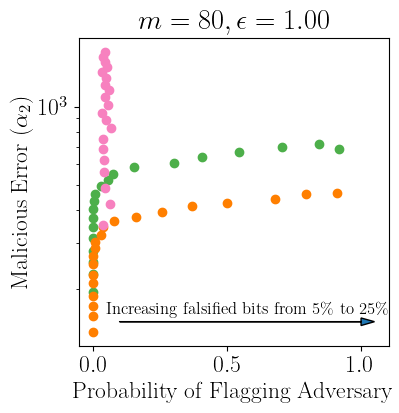

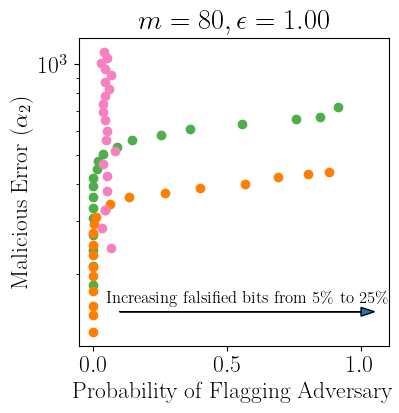

In [628]:
def do_adp_plot(df_poi, g_name, n_mal, f_name):
    fig, ax = plt.subplots(figsize=(4,4))
    patches = []
    P = df_poi.loc[:, '2 Inf Comm', g_name, :]
    n_nodes = g.get_size()
    colors = [CB_color_cycle[2], CB_color_cycle[1], CB_color_cycle[3]]
    markers = ['o', 'o', 'o']
    eps = P['Eps']
    assert (eps.min() == eps.max())
    eps = eps.max()
    att_names = ['RR+Laplace, Response', 'RR, Response', 'Naive, Response']
    for i in range(0, len(att_names)):
        Q = P.loc[att_names[i], :]
        y = Q['Mal Mean Error']
        x = Q['Mal T Nan'] / Q['Mal T Tot']
        #alphas = np.linspace(0.4, 1.0, len(x))
        #for j in range(0, len(x)):
        pN = ax.scatter(x, y, color=colors[i], marker=markers[i])
        #pdb.set_trace()
        patches.append(pN)
    ax.set_xlabel('Probability of Flagging Adversary')
    ax.set_ylabel(r'Malicious Error $(\alpha_2)$')
    ax.set_title(r'$m = %d, \epsilon = %0.2f$' % (int(n_mal), eps))
    ax.set_yscale('log')
    ax.arrow(0.1, 150, 0.9, 0, head_length=0.05, head_width=10)
    ax.annotate('Increasing falsified bits from 5\\% to 25\\%', (0.05,160), size=12)
    plt.savefig(f_name, bbox_inches='tight')
    return patches

patches = do_adp_plot(DFP, 'FB', g.get_size() * 0.02, path+'fb_poi.pdf')
do_adp_plot(DFP, 'GNP', gnp.get_size() * 0.02, path+'gnp_poi.pdf')

In [627]:
labels = ['Hybrid', 'RRCheck', 'SimpleRR with Baseline Def.']
#labels.insert(2, 'Some Malicious Users Flagged ($\perp$ returned)')
legendFig = plt.figure("Legend plot")
legendFig.legend(patches, labels, loc='center', ncol=3)
legendFig.savefig(path + 'poi-legend.pdf', bbox_inches='tight')
#legendFig.show()

<Figure size 400x400 with 0 Axes>

# n_mal > m experiments

In [312]:
def collect_data_supermal(attack_names, g, g_name, adv_known, n_actual_mal, epsilons, thresh_values, attack_values, comm, reps):
    labels = ['RR+Laplace, Response', 'RR, Response', 'Naive, Response']
    E = [experiments.ResponseLaplaceManipulation(g, adv_known, 1.0, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.5]), 
         #experiments.InputLaplaceManipulation(g, max_adv, 1.0, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.5]),
         experiments.ResponseRRManipulation(g, adv_known, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         #experiments.InputRRManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         experiments.ResponseRRNaiveManipulation(g, adv_known, 1.0, 1e-6, [0.7], [0.8, 0.5])
         #experiments.InputRRNaiveManipulation(g, max_adv, 1.0, 1e-6, [0.7], [0.8, 0.5])
        ]
    data = []
    for x in range(0, reps):
        for n_mal in n_actual_mal:
            t2 = int(n_mal // 6)
            if attack_names[0] == 'Inf+Def Comm':
                attacks = [ [(t2, t2, n_mal-t2, list(comm))] ]
            elif attack_names[0] == '2 Inf Comm':
                attacks = [ [(t2, 0, n_mal // 2 - t2, list(comm)), (t2, 0, n_mal // 2 - t2, list(comm))] ]
            else:
                assert False
            #pdb.set_trace()
            for epsilon in epsilons:
                for exp in E:
                    exp.set_epsilon(epsilon)
                for a_i in range(0, len(attacks)):
                    for i in range(0, len(E)):
                        E[i].reset_attacks()
                        E[i].max_num_mal = n_mal
                    E[0].add_attacks(attacks[a_i])
                    for i in range(1, len(E)):
                        E[i].set_attacks_like(E[0])
                    for exp in E:
                        #Falsely set attacks too low
                        exp.max_num_mal = adv_known
                    #pdb.set_trace()
                    for av in attack_values.keys():
                        for tv in thresh_values.keys():
                            for i in range(0, len(E)):
                                E[i].threshold_reduction = thresh_values[tv]
                                if 'Naive' in labels[i]:
                                    E[i].inflation_factors = (1.0,)
                                else:
                                    E[i].inflation_factors = attack_values[av] 
                                d = E[i].get_results(False)
                                h = {'Protocol': labels[i], 'Attack': attack_names[a_i], 'Attack Strength': av, 'Threshold Strength': tv, 'Eps': epsilon, 'Graph': g_name,
                                    'Mal Max Error': d[0][0], 'Mal L2 Error': d[0][1], 'Mal Mean Error': d[0][2], 'Mal T Nan': d[1][0], 'Mal T Tot': d[1][1], 'Mal Nan': d[2],
                                    'Num Mal': n_mal, 'Hon T Max Error': d[3][0], 'Hon T L2 Error': d[3][1], 'Hon T Mean Error': d[3][2], 'Hon T Nan': d[4][0], 'Hon T Tot': d[4][1],
                                    'Rest Max Error': d[5][0], 'Rest L2 Error': d[5][1], 'Rest Mean Error': d[5][2], 'Rest Nan': d[6][0], 'Rest Tot': d[6][1]
                                }
                                data.append(h)
    return data

In [313]:
data_vary_n_supermal = collect_data_supermal(['Inf+Def Comm'], g, 'FB', 40, np.arange(40, 800, 50), [3.0], thresh_values, attack_values, list(comms[1]) + list(comms[0]), 15)
data_vary_n_supermal_gnp = collect_data_supermal(['Inf+Def Comm'], gnp, 'GNP', 40, np.arange(40, 800, 50), [3.0], thresh_values, attack_values, list(comms[1]) + list(comms[0]), 15)

In [314]:
pickle.dump((data_vary_n_supermal, data_vary_n_supermal_gnp), open('df-supermal.pkl', 'wb'))
df_sup = pd.concat((pd.DataFrame(data_vary_n_supermal), pd.DataFrame(data_vary_n_supermal_gnp)))

In [316]:
DF_sup = df_sup.drop(['Attack Strength', 'Threshold Strength'], axis=1).groupby(['Protocol', 'Attack', 'Eps', 'Graph', 'Num Mal']).mean()

In [650]:
def do_super_plots(DF_sup, g, graph_name, n_mal, f_name):
    fig1, ax = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    P = DF_sup.loc[:, 'Inf+Def Comm', :, graph_name, :]
    n_nodes = g.get_size()
    colors = [CB_color_cycle[2], CB_color_cycle[1]]
    #markers = ['^', 'o', '^', 'o', '^', 'o']
    att_names = ['RR+Laplace, Response', 'RR, Response']
    for i in range(0, len(att_names)):
        Q = P.loc[att_names[i]]
        eps_list = Q.index.get_level_values(0)
        assert eps_list.max() == eps_list.min()
        eps = eps_list.max()
        Q = Q.loc[eps, :]
        x = Q.index.get_level_values(0)
        y1 = (Q.loc[x]['Hon T Nan'] + Q.loc[x]['Rest Nan']) / (Q.loc[x]['Hon T Tot'] + Q.loc[x]['Rest Tot'])
        y2 = Q.loc[x]['Hon T Max Error']
        y3 = Q.loc[x]['Mal Max Error']
        ax.scatter(x, y1, c = colors[i], marker='o')
        ax2.scatter(x, y2, c=colors[i], marker='o')
        ax3.scatter(x, y3, c=colors[i], marker='o')
    ax3.set_xlabel(r'True Num. of Malicious Users $(m^{\prime})$')
    ax3.set_ylabel(r'Malicious Error $(\alpha_2)$')
    ax.set_xlabel(r'True Num. of Malicious Users $(m^{\prime})$')
    ax.set_ylabel(r'FPR')
    ax2.set_xlabel(r'True Num. of Malicious Users $(m^{\prime})$')
    ax2.set_ylabel(r'Honest Error $(\alpha_1)$')
    ax.set_title(r'$m = %d, \epsilon = %0.2f$' % (int(n_mal), eps))
    fig1.savefig(f_name + '-fpr.pdf', bbox_inches='tight')
    fig2.savefig(f_name + '-hon-error.pdf', bbox_inches='tight')
    fig3.savefig(f_name + '-mal-error.pdf', bbox_inches='tight')

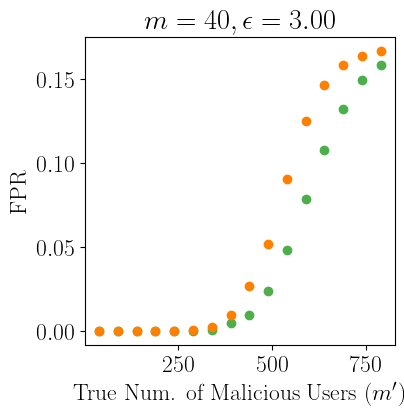

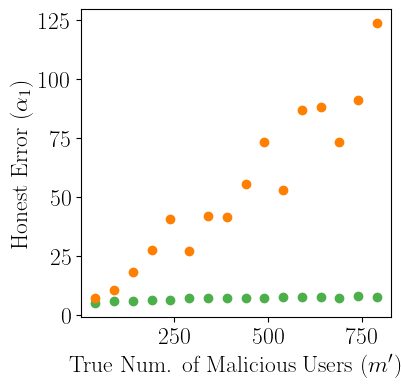

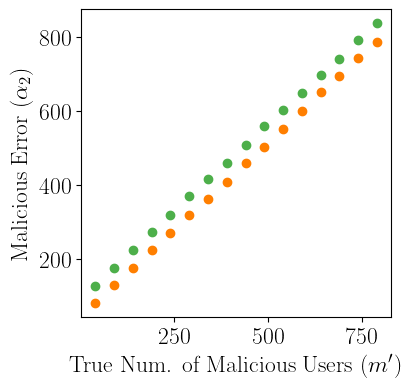

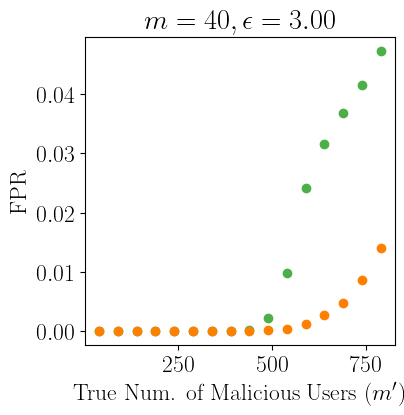

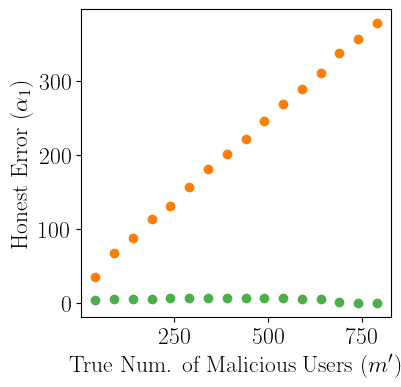

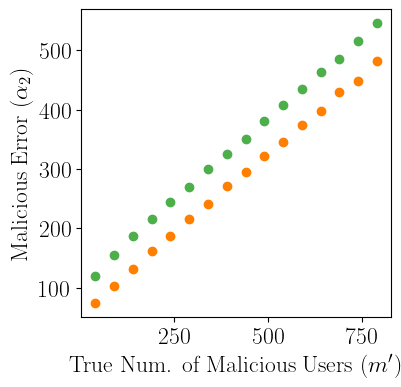

In [651]:
do_super_plots(DF_sup, g, 'FB', 40, path+'fb-super')
do_super_plots(DF_sup, gnp, 'GNP', 40, path+'gnm-super')

In [ ]:
for i in range(0, len(att_names)):
    Q = P.loc[att_names[i], :]
    x = Q['Hon T Max Error']
    y = Q['Mal Max Error']
    nan = Q['Mal T Nan']
    alphas = np.linspace(0.4, 1.0, len(x))
    for j in range(0, len(x)):
        ax.scatter(Q['Hon T Max Error'].iloc[j], Q['Mal Max Error'].iloc[j], c=colors[i], marker=markers[i], alpha = alphas[j])
        if nan.iloc[j] > 0:
            ax.scatter(Q['Hon T Max Error'].iloc[j], Q['Mal Max Error'].iloc[j], c='k', marker='x', zorder=5, s=50)

#ax.plot((0, width), (height, height), color='#f781bf', linewidth=1.5)
#ax.plot((width, width), (height, 0), color='#f781bf', linewidth=1.5)
#ax.hlines(height, 0, 5*n_nodes, color='#f781bf', linestyle='dotted')
#ax.vlines(width, 0, 5*n_nodes, color='#f781bf', linestyle='dotted')
ax.set_xlabel(r'Honest Error $(\alpha_1)$')
ax.set_ylabel(r'Malicious Error $(\alpha_2)$')
ax.set_yscale('log')
ax.set_ylim([100, 5*n_nodes])
ax.set_xlim([10, 5*n_nodes])
ax.set_xscale('log')
ax.set_title(r'$m = \{1\%, 2\%, \ldots, 33\%\}, \epsilon = 0.7$')
#ax.annotate(r'$$d_{95}$$', (2.5*n_nodes, height * 1.2), fontsize=16)
#ax.annotate(r'$$d_{95}-d_{80}$$', (1.2*width, 3.5*n_nodes), fontsize=16)
plt.savefig(name, bbox_inches = "tight")
#Add asymptote for naive.

# Large community experiments

In [554]:
class weightedUF:
    _id = []
    _sz = []
    _count = 0;

    def __init__(self, N):
        self._id = list(range(0,N))
        self._count = N
        self._sz = [1]*N
        #print(self._sz)
    
    #Quick-union
    def find(self, p):
        while (self._id[p] != p):
            p = self._id[p]
        return p

    def union(self, p, q):
        self._rootP = self.find(p)
        self._rootQ = self.find(q)

        if (self._rootP == self._rootQ):
            return 0

        if (self._sz[self._rootP]<self._sz[self._rootQ]):
            self._id[self._rootP] = self._rootQ
            self._sz[self._rootQ] += self._sz[self._rootP]
            sz = self._sz[self._rootQ]
        else:
            self._id[self._rootQ] = self._rootP
            self._sz[self._rootP] += self._sz[self._rootQ]
            sz = self._sz[self._rootP]

        self._count = self._count-1
        return sz
    
    def connected(self, p, q):
        return self.find(p) == self.find(q)
        
    def count(self):
        return self._count

In [583]:
def resp_adj_matrix(M, k, eps, resp_poi = False):
    rho = 1 / (1 + np.exp(eps))
    n = M.shape[0]
    M_new = np.zeros((n+k, n+k), dtype=int)
    M_new[:n, :n] = M
    M_new[n:, n:] = 1
    RR = np.random.choice([0,1], (n+k,n+k), p=[1-rho, rho])
    M_new ^= RR
    #for i in range(0, n+k):
    #    M_new[i, i] = 0
    #    M_new[i, i+1:] = M_new[i+1:, i]
    if resp_poi:
        M_new[n:, n:] = 1
    return M_new
#G_new = nx.Graph(M_new)

In [584]:
def uf_detect(inp, n, k):
    uf = weightedUF(n+k)
    idxs = sorted( [(inp[i,j], i,j) for i in range(0, n+k) for j in range(0, i)] )
    i = len(idxs)-1
    while True:
        w, u, v = idxs[i]
        sz = uf.union(u, v)
        if sz >= k:
            break
        i -= 1
    L = [uf.find(i) for i in range(n, n+k)]
    return L

In [585]:
def detect(M, k, eps, resp_poi):
    n = M.shape[0]
    M_new = resp_adj_matrix(M, k, eps, resp_poi)
    sims = M_new @ M_new.T
    for i in range(n):
        sims[i,i] = 0
    v = np.sqrt( sims.sum(axis=1) ).reshape((1, -1))
    sims = sims / (v.T @ v)
    #plt.matshow(sims)
    L = uf_detect(sims, n, k)
    return min(L) == max(L)

In [586]:
def bin_search_detect(M, i_min, i_max, eps, reps, resp_poi=False):
    assert i_min < i_max
    while(i_min+1 < i_max):
        print(i_min, i_max)
        mid = (i_min + i_max) // 2
        always_detected = True
        for j in range(reps):
            always_detected = always_detected and detect(M, mid, eps, resp_poi)
            if not always_detected:
                break
        if always_detected:
            #mid is too high
            i_max = mid
        else:
            i_min = mid
    return i_min

In [567]:
bin_search_detect(g.get_adj_matrix(), 12, 512, 3.0, 4)

12 512
12 262
12 137
74 137
105 137
121 137
121 129
125 129
125 127


126

In [570]:
bin_search_detect(g.get_adj_matrix(), 12, 1024, 0.7, 4)

12 1024
518 1024
518 771
518 644
518 581
518 549
533 549
541 549
545 549
547 549


548

In [581]:
bin_search_detect(gnp.get_adj_matrix(), 1024, 2048, 0.7, 4)

1024 2048
1536 2048
1536 1792
1536 1664
1536 1600
1536 1568
1536 1552
1544 1552
1544 1548
1544 1546


1544

In [582]:
bin_search_detect(gnp.get_adj_matrix(), 12, 512, 3.0, 4)

12 512
12 262
12 137
74 137
105 137
105 121
105 113
109 113
111 113


111

In [587]:
bin_search_detect(g.get_adj_matrix(), 12, 512, 3.0, 4, True)

12 512
12 262
12 137
74 137
105 137
105 121
105 113
105 109
105 107


106

In [589]:
bin_search_detect(g.get_adj_matrix(), 12, 1024, 0.7, 4, True)

12 1024
12 518
12 265
138 265
138 201
138 169
153 169
153 161
153 157
153 155


154

In [590]:
bin_search_detect(gnp.get_adj_matrix(), 12, 2048, 0.7, 4, True)

12 2048
12 1030
12 521
266 521
393 521
393 457
393 425
409 425
409 417
413 417
415 417


416

In [592]:
bin_search_detect(gnp.get_adj_matrix(), 12, 512, 3.0, 4, True)

12 512
12 262
12 137
74 137
74 105
89 105
97 105
97 101
99 101


99

In [474]:
max([sims[:n, :n].max(), sims[n:, :n].max(), sims[:n, n:].max()])

np.float64(0.0011760152180607406)

In [475]:
mini = sims[-1, -2]
for i in range(n, n+k-1):
    mini = min(mini, sims[i, i+1:].min())

In [476]:
mini

np.float64(0.0007763331770889842)

In [477]:
mst_weight(sims[n:, n:], k)

np.float64(0.0008233566432478827)

In [510]:
import heapq
def mst_weight(inp, k):
    H = [[0, k-1, k-1]]
    min_weight = 0
    visited = [0] * k
    cluster_ids = list(range(k))
    while len(H) > 0:
        w, v, c = heapq.heappop(H)
        if not visited[v]:
            visited[v] = 1
            min_weight = min(min_weight, w)
            for i in range(0, k):
                if not i == v:
                    heapq.heappush(H, [-inp[i, v], i])
    return -min_weight